In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import scipy
import math

# Quantizer without noise

In [81]:
points = []
centroids = []
num_points = 10**5
num_centroids = 2
e=0.0001

for i in range(num_points):
    points.append(np.random.normal())
for i in range(num_centroids):
    centroids.append(np.random.normal())

points = np.array(points)
centroids = np.array(centroids)

In [82]:
def grouping(point_array, centroid_array):
    #grouping the centroids into groups
    grouping = []
    return_list = {}
    centroid_array = np.sort(centroid_array)
    for i in range(len(centroid_array)-1):
        midpoint = (centroid_array[i]+centroid_array[i+1])/2
        grouping.append(midpoint)
    for i in range(len(grouping)+1):
        if i ==0:
            return_list[i] = point_array[np.where(point_array<grouping[i])]
        if i == len(grouping):
            return_list[i] = point_array[np.where(point_array>grouping[i-1])]
        if i!=0 and i!= len(grouping):
            return_list[i] = point_array[np.where(np.logical_and(point_array>grouping[i-1], point_array<grouping[i]))]
        
    return return_list

In [83]:
def new_centroids(points):
    new_centroid_points = []
    for i in range(len(points)):
        new_centroid_points.append(points[i].mean())
    return new_centroid_points

In [84]:
def distortion(points, centroids):
    total_dis = 0
    for i in range(len(points)):
        dis = np.square(np.array(points[i])-centroids[i]).sum() #distortion for each cluster
        total_dis = total_dis + dis
    return total_dis

In [85]:
def lloydsalgorithm(point_array, centroid_array, distortion_list):
    previous_centroids = centroid_array
    groups = grouping(point_array, centroid_array)
    
    new_centroid_array = new_centroids(groups)
    new_groups = grouping(point_array, new_centroid_array)

    prev_dis = distortion(groups, previous_centroids)
    new_dis = distortion(new_groups, new_centroid_array)
    distortion_list.append(prev_dis)

    if np.abs(prev_dis-new_dis)/prev_dis<e:
        return new_centroid_array, distortion_list
    else:
        return lloydsalgorithm(point_array, new_centroid_array, distortion_list)
    


In [86]:
centroids, distortions =lloydsalgorithm(points, centroids, [])

In [87]:
df = pd.DataFrame(distortions)

Text(0, 0.5, 'Mean Squared Error')

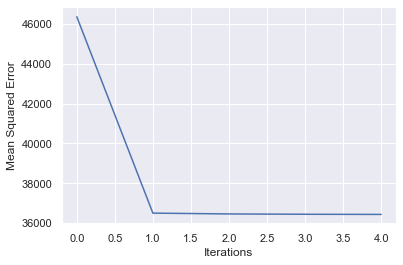

In [88]:
sns.set_theme()
ax = sns.lineplot(data = df, y=0, x=df.index,  markers=True, dashes=False)
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean Squared Error")

# Quantizer with Noise

In [89]:
iterations = 10**5
num_centroids = 2
training_set = []
centroids = []
epsilon = 0.1

transition_matrix = np.matrix([[1 - epsilon, epsilon], [epsilon, 1-epsilon]])

for i in range(iterations):
    training_set.append(np.random.normal())

for i in range(num_centroids):
    centroids.append(np.random.normal())

In [90]:
def distortion_w_noise(groups, centroids, transition_matrix):
    dimension1, dimension2 = transition_matrix.shape
    distortion = 0
    for i in range(dimension1):
        sub_add = 0
        for j in range(len(groups)):
            for point in groups[j]:
                sub_add = sub_add + (point- centroids[i])**2
        distortion = distortion + transition_matrix[i,j]*sub_add
    return distortion


In [91]:
def distortion(point, centroid, prob):
    return prob*(point - centroid)**2

In [117]:
def ub_distortions(point, centroids, transition_matrix):
    i, j = transition_matrix.shape
    distortions = []
    for indexi in range(i): # will put value in index i of the distortion array
        sum = 0
        for indexj in range(j):
            sum = sum + transition_matrix[indexi, indexj]*(point-centroids[indexj])**2
        distortions.append(sum)
    return np.array(distortions).argmin()
    # returns which subsection the points belongs to

In [118]:
def grouping_w_noise(centroids, points, transition_matrix):
    distance = {}
    #initialize dictionary with arrays

    dimension1, dimension2 = transition_matrix.shape
    for i in range(dimension1):
        distance[i] = []

    for point in points:
        index = ub_distortions(point, centroids, transition_matrix)
        distance[index].append(point)
    return distance

In [123]:
def new_centroids_w_noise(grouping, transition_matrix):
    #weighted average for each section
    dimension1, dimension2 = transition_matrix.shape
    centroid_list ={}
    for i in range(dimension1):
        numerator = 0
        denominator = 0
        for j in range(dimension2):
            numerator = numerator + transition_matrix[i,j] * np.array(grouping[j]).sum()
            denominator = denominator + transition_matrix[i,j]* len(grouping[j])
        centroid_list[i] = numerator/denominator
    return centroid_list


In [124]:
for i in range(2):
    print(i)

0
1


In [125]:
def lloydsalgorithm_w_noise(training_set, centroid_array, distortion_list, transition_matrix):
    previous_centroids = centroid_array
    groups = grouping_w_noise(centroid_array, training_set, transition_matrix)

    new_centroids = new_centroids_w_noise(groups, transition_matrix)
    new_groups = grouping_w_noise(new_centroids, training_set, transition_matrix)

    new_dist = distortion_w_noise(new_groups, new_centroids, transition_matrix)
    prev_dist = distortion_w_noise(groups, previous_centroids, transition_matrix)

    distortion_list.append(prev_dist)
    if abs(new_dist-prev_dist)/prev_dist > 0.001:
        print(new_centroids)
        print(new_dist/num_points)
        return lloydsalgorithm_w_noise(training_set, new_centroids, distortion_list, transition_matrix)
    else:
        return distortion_list, new_centroids


In [126]:
lloydsalgorithm_w_noise(training_set, centroids, [], transition_matrix)

{0: -0.3752906317628798, 1: 0.8420118501340197}
1.6525360213577107
{0: -0.5415094357275355, 1: 0.727887934562579}
1.5062652506780743
{0: -0.6000764958374465, 1: 0.6748807382830693}
1.4459120238889864
{0: -0.6228008531497203, 1: 0.6529716825196091}
1.4224596915139711
{0: -0.631870224210326, 1: 0.6440182431964615}
1.4131265791966199
{0: -0.6356529351337121, 1: 0.6402477595396758}
1.409239663262494
{0: -0.6372452650320021, 1: 0.6386554413371834}
1.4076060637298209


([317346.81547827326,
  165253.60213577107,
  150626.52506780744,
  144591.20238889864,
  142245.96915139712,
  141312.657919662,
  140923.96632624939,
  140760.6063729821],
 {0: -0.6379899971782882, 1: 0.6379099201454588})